© 2018 Suzy Beeler. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

This exercise was generated from a Jupyter notebook. You can download the notebook [here](lacI_titration_day1.ipynb).
___

# Objective 

In this tutorial, we will be embarking on a large endeavor to compare theory and experiment in the context of gene expression in *E. coli*. In lecture, we derived a mathematical prediction of how the expression of a reporter gene (YFP) should change in response to increasing copy number of the LacI repressor. Here, we will make plots of our predictions as well as go through all the data analysis needed to plot the data on top of our theory to see how they compare.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
sns.set(style='ticks', rc=rc)

# Part 1: Plot the theory curves

To show that we haven't "cooked the books," we always want to plot our theory first. As we derived in lecture, our predicted fold change equation is

$$ \text{fold-change}(R) = \frac{1}{1 + \frac{R}{N_{NS} \ e^ {-\beta \Delta \epsilon_R}}}, \tag{1}$$

where $R$ is the copy number of the LacI repressor, $N_{NS}$ is the number of non-specific binding sites in the genome (which we take to be the length of the genome), and $\Delta \epsilon$ is the binding energy of the binding site to the repressor. Below, we plot the theory curves for three LacI binding sites: O1, O2, and O3 which having binding energies of $-15.3 k_BT$, $-13.9 k_BT$, and $-9.3 k_BT$ respectively. 

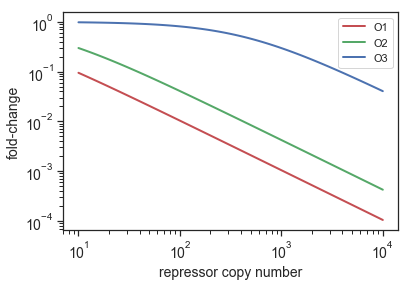

In [2]:
# number of non-specific sites
NNS = 4.6E6

# repressor binding energies in kT units
dE = [-15.3, -13.9, -9.3]

# range of repressor copy numbers 10^1 to 10^4
R_range = np.logspace(1, 4, 100)

# colors to use in the plot
colors = ['r', 'g', 'b']

# compute and plot the theoretical predictions
for i in range(3):
    fold_change = 1/(1 + R_range/NNS * np.exp(-dE[i]))
    plt.loglog(R_range, fold_change, color=colors[i])

plt.xlabel("repressor copy number")
plt.ylabel("fold-change")
plt.legend(["O1","O2","O3"])

# Part 2: Using phase images to get segmentation masks

At the end of the day, we are interesting in determining the amount of YFP expression in *E. coli* with varying copy numbers of LacI. Before we can assess the amount of fluorescence, we first need to find where the cell are in the images. To do this, it's important to use a channel that is independent of the reporter gene, so we will be using phase images to get our segmentation masks. 

## 2.1: Background subtraction

Let's first look at a sample image.

In [3]:
# Show images in greyscale by default
plt.rcParams['image.cmap'] = 'Greys_r'

# For extracting pathnames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure

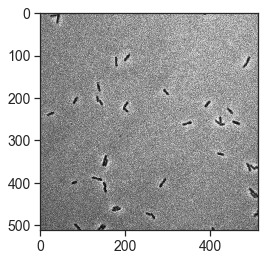

In [4]:
# Read an example phase contrast image
im = skimage.io.imread('data/lacI_titration/O2_R22_phase_pos_19.tif')

# Show the image
plt.imshow(im)

This image is very noisy, and unevenly illuminated. We can fix this by *background subtracting* the image. To get the "background" we need to blur the image, removing any fine-detail structures (like the bacteria). 

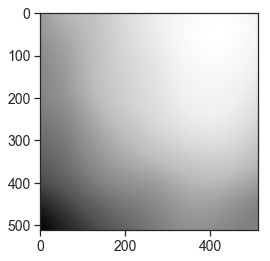

In [5]:
# normalize it
im_float = (im - np.min(im))/(np.max(im)-np.min(im))

# find the background
gauss_radius = 50
im_bg = skimage.filters.gaussian(im_float, sigma=gauss_radius)

# show the background
plt.imshow(im_bg)

Now that we have the background image, we can subtract it from the original image.

Text(0.5,1,'Background-subtracted image')

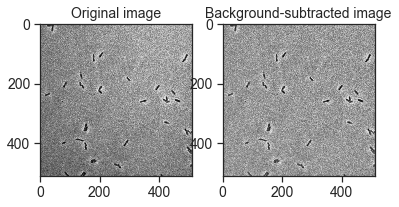

In [6]:
# Perform a background subtraction
im_bs = im_float - im_bg

# Show the background-subtracted image
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_float)
ax[0].set_title('Original image')

ax[1].imshow(im_bs)
ax[1].set_title('Background-subtracted image')

## 2.2: Thresholding

Now that we have cleaned up the image a little bit, we're good to start distinguishing bacteria from background. We will do these by *thresholding* the image, similar to how we did [on the first day](bacterial_growth.html). To figure out a good threshold, let's plot the histogram of pixel intensities. 

Text(0,0.5,'count')

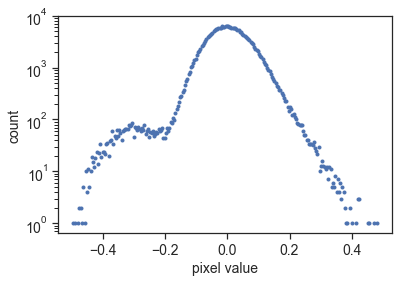

In [7]:
hist, pixel_vals = skimage.exposure.histogram(im_bs)

plt.plot(pixel_vals, hist, '.')
plt.yscale('log')
plt.xlabel('pixel value')
plt.ylabel('count')

By plotting with the $y$-axis logarithmically scaled, we can distinguish one hump of low pixel intensities

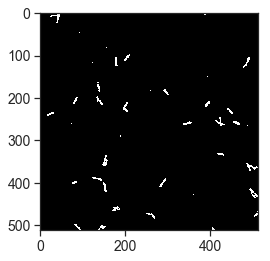

In [8]:
# Choose a threshold
threshold = -0.2

# Thresholded image
im_thresh = im_bs < threshold

# Show the thresholded image
plt.imshow(im_thresh)

## 2.3: Label and get sizes of the objects in the image

In [9]:
# Label the objects in the binary image
im_label, n_objects = skimage.measure.label(im_thresh, return_num = True)

# Print the number of objects found
print(str(n_objects) + ' objects are found in the binary image')

87 objects are found in the binary image


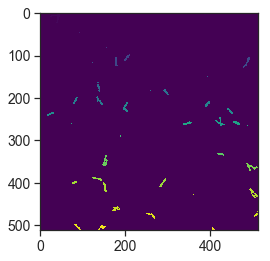

In [10]:
# Show the labeled image in a colored scale
plt.imshow(im_label, cmap = plt.cm.viridis)

Text(0,0.5,'count')

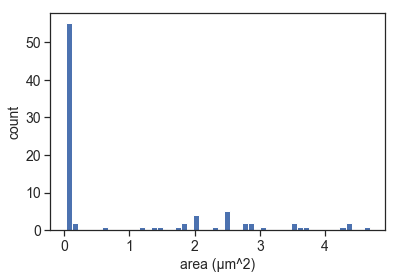

In [11]:
# Length calibration in um/pixel
pixel_size = 0.16

# List to store area values in um^2
areas = []

# Obtain the areas of all labeled objects
objs = skimage.measure.regionprops(im_label)

for obj in objs:
    areas.append(obj.area * pixel_size**2)
    
# Take a look at the distribution
_ = plt.hist(areas, bins = 50)
plt.xlabel('area (µm^2)')
plt.ylabel('count')

## 2.4: Remove non-bacteria objects from the image.

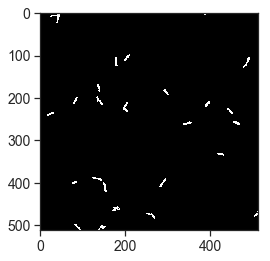

In [12]:
# area threshold for what we call a bacteria
lower_area = 1 # µm^2
upper_area = 4 # µm^2

# Create a 2d array of zeros
im_mask = np.zeros_like(im_thresh)

for obj in objs:
    area = obj.area * pixel_size**2
    if (area > lower_area) and (area < upper_area):
        im_mask = im_mask + (im_label == obj.label)
        
plt.imshow(im_mask)

In [13]:
# Label the remaining objects
im_mask_label, n_objects_mask = skimage.measure.label(im_mask, return_num = True)

# Print the number of object after size filtering
print(str(n_objects_mask) + ' objects remain after filtering')

25 objects remain after filtering


## 2.5 Write a masking function

In [14]:
def create_mask(phase_image, gauss_radius = 50, threshold = -0.2, \
                 pixel_size = 0.16, lower_area = 1, upper_area = 4):
    
    # normalize
    im_float = (phase_image - np.min(phase_image))/(np.max(phase_image)-np.min(phase_image))
    
    # find the background
    im_bg = skimage.filters.gaussian(im_float, gauss_radius)
    
    # subtract the background
    im_bs = im_float - im_bg
    
    # Threshold the image
    im_thresh = im_bs < threshold
    
    # Label the image
    im_label = skimage.measure.label(im_thresh)
    
    # Obtain the features of the objects
    props = skimage.measure.regionprops(im_label)
    
    # Remove small objects
    im_mask = np.zeros_like(im_label)
    for prop in props:
        area = prop.area * pixel_size**2
        if (area > lower_area) and (area < upper_area):
            im_mask = im_mask + (im_label == prop.label)
            
    # Label the mask
    im_mask_label = skimage.measure.label(im_mask)
    
    # Return the labeled mask
    return im_mask_label

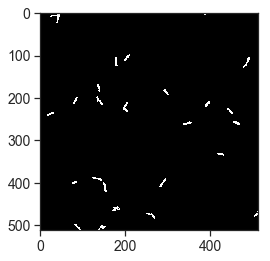

In [15]:
test_mask = create_mask(im)

plt.imshow(im_mask)

# Step 3: Use our segmentation mask to get fluorescence intensities from a YFP image

Text(0.5,1,'Mask')

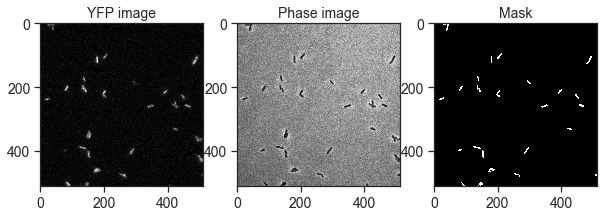

In [16]:
# Read the matching YFP image
im_yfp = skimage.io.imread('data/lacI_titration/O2_R22_yfp_pos_19.tif')

# Show them next to each other
fig, ax = plt.subplots(1,3, figsize=[10,3])
ax[0].imshow(im_yfp)
ax[0].set_title('YFP image')

ax[1].imshow(im)
ax[1].set_title('Phase image')

ax[2].imshow(im_mask)
ax[2].set_title('Mask')

Text(0,0.5,'Count')

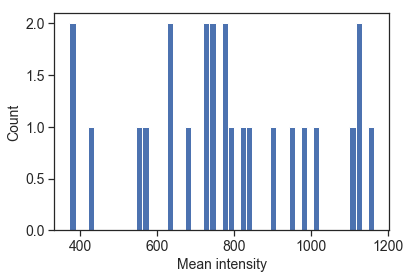

In [17]:
# List to store the object intensity values
intensities = []

# Obtain the features of objects in the YFP channel
objs = skimage.measure.regionprops(im_mask_label, intensity_image=im_yfp)

# Add the YFP intensity values
for obj in objs:
    intensities.append(obj.mean_intensity)
    
# Histogram of intensity values
_ = plt.hist(intensities, bins = 50)
plt.xlabel('Mean intensity')
plt.ylabel('Count')